In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import sys
import seaborn as sns
from scipy.special import comb
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.colors import LogNorm
import matplotlib as mpl
import pandas as pd
import itertools as it
import matplotlib.colors as colors

from mutation_info import *

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return it.chain.from_iterable(it.combinations(s, r) for r in range(len(s)+1))

plt.rcParams.update({'font.size': 7})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams["xtick.major.size"] = 2
plt.rcParams["ytick.major.size"] = 2

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


In [2]:
# set some things
num_mutations_H1 = 16
order_H1 = 5
num_term_list_H1 = np.array([int(comb(num_mutations_H1,i)) for i in range(1,order_H1+1)])
total_params_H1 = sum(num_term_list_H1)
order_start_indices_H1 = list(np.cumsum(num_term_list_H1)+1)
order_start_indices_H1.insert(0,1)
print(num_term_list_H1,total_params_H1)
print(order_start_indices_H1)

num_mutations_H3 = 13
order_H3 = 4
num_term_list_H3 = np.array([int(comb(num_mutations_H3,i)) for i in range(1,order_H3+1)])
total_params_H3 = sum(num_term_list_H3)
order_start_indices_H3 = list(np.cumsum(num_term_list_H3)+1)
order_start_indices_H3.insert(0,1)
print(num_term_list_H3,total_params_H3)
print(order_start_indices_H3)


mut_names = ['30','35','36','57','64','65','66','79','82','83','84','85','92','95','103','113']

H1_color = '#e8735c'
H3_color = '#72c2a6'
B_color = '#5482a7'
H9_color = 'rebeccapurple'


ep_type = 'stat'

[  16  120  560 1820 4368] 6884
[1, 17, 137, 697, 2517, 6885]
[ 13  78 286 715] 1092
[1, 14, 92, 378, 1093]


# H1

In [3]:
# read model coefficients


coefs_H1 = np.zeros(total_params_H1+1)
stderr_H1 = np.zeros(total_params_H1+1)
names_H1 = []
sig_H1 = np.full((total_params_H1+1),0)
cis_H1 = np.zeros((total_params_H1+1,2))

with open('../../../CR9114/Epistasis_linear_models/model_coefs/H1_'+str(order_H1)+'order_'+ep_type+'.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2_train = float(next(coef_reader)[-1])
    print(r2_train)
    header = next(coef_reader)
    print(header)
    for i in range(total_params_H1+1):
        row = next(coef_reader)
        names_H1.append(row[0])
        coefs_H1[i] = float(row[1])
        if i >= 1:
            stderr_H1[i] = float(row[2])
            cis_H1[i,0] = float(row[4])
            cis_H1[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_H1[i] = 1
    readfile.close()
            
print(len(coefs_H1))      

0.97351889734628
['Term', 'Coefficient', 'Standard Error', 'p-value', '95% CI lower', '95% CI upper']
6885


0.0 0.5942704153396922


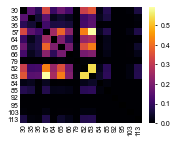

In [6]:
# initialize matrices to store values

# total (lower diagonal)
total_epistasis = np.zeros((16,16),dtype=float)
for i in range(16):  
    total_epistasis[i,i] = np.nan


# add up all coefficients
for i in range(1,len(coefs_H1)):

    muts_involved = [int(x)-1 for x in names_H1[i].split(',')]
    
    # only consider 3rd order and higher
    if len(muts_involved) >= 3:
        if sig_H1[i]:
            for j in range(len(muts_involved)):
                for k in range(j+1,len(muts_involved)):
                    total_epistasis[muts_involved[k],muts_involved[j]] += np.abs(coefs_H1[i])
                    total_epistasis[muts_involved[j],muts_involved[k]] += np.abs(coefs_H1[i])


print(np.nanmin(total_epistasis),np.nanmax(total_epistasis))

# normalize total epistasis
#print(total_sum,total_sum_signed)
#total_epistasis = total_epistasis/total_sum
#print(np.nanmin(total_epistasis),np.nanmax(total_epistasis))
min_val = np.nanmin(total_epistasis)


#cbar_ticks = [10**i for i in range(int(np.floor(np.log10(np.nanmin(total_epistasis)))), 1+int(np.ceil(np.log10(np.nanmax(total_epistasis)))))]
# for i in range(16):
#     total_epistasis[i,i] = min_val
    
sns.set_style({"axes.facecolor": "k"})       
plt.figure(figsize=(2.5,2))
sns.heatmap(total_epistasis,cmap='inferno',cbar_kws={"pad": 0.05}) #,vmin=0.0,vmax=np.nanmax(total_epistasis)) 
plt.xticks(np.arange(0.5,num_mutations_H1+0.5,1),mut_names,rotation='90')
plt.yticks(np.arange(0.5,num_mutations_H1+0.5,1),mut_names,rotation='0')
plt.tick_params(length=0,pad=1)
#plt.title('H1, 3rd-5th Order Epistasis')



plt.tight_layout()
plt.savefig('images/9114_H1_3andup_total_'+ep_type+'.pdf')
plt.show()



31


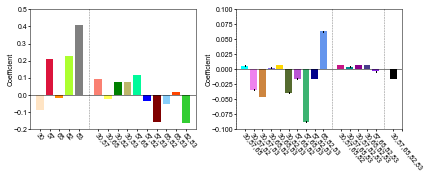

In [12]:
# 
sns.set_style({"axes.facecolor": "w"})       

muts_to_consider = [1,4,6,9,10]

coefs = {}

num_sig = 0

for s in powerset(muts_to_consider):
    if len(s) >= 1: 
        name = ','.join([str(x) for x in s])
        if cis_H1[names_H1.index(name)][0]*cis_H1[names_H1.index(name)][1] > 0: num_sig += 1
        coefs[name] = [coefs_H1[names_H1.index(name)],stderr_H1[names_H1.index(name)]]
        
print(num_sig)
namedict = {'-':'germline','1':'30','4':'57','6':'65','9':'82','10':'83'}

order = ['1','4','1,4','6','1,6','9','1,9','4,6','1,4,6','6,9','1,6,9','4,9','1,4,9','4,6,9','1,4,6,9',
        '10','1,10','4,10','1,4,10','6,10','1,6,10','9,10','1,9,10','4,6,10','1,4,6,10','6,9,10','1,6,9,10','4,9,10','1,4,9,10','4,6,9,10','1,4,6,9,10']
colordict = {'gray':'#808080','darkolivegreen':'#556b2f','maroon2':'#7f0000','darkslateblue':'#483d8b',
            'green':'#008000','mediumseagreen':'#3cb371','darkkhaki':'#bdb76b','peru':'#cd853f',
             'lightseagreen':'#20b2aa','darkblue':'#00008b','limegreen':'#32cd32','darkmagenta':'#8b008b',
             'maroon3':'#b03060','orangered':'#ff4500','darkorange':'#ff8c00','lime':'#00ff00',
             
             'mediumspringgreen':'#00fa9a','blueviolet':'#8a2be2','crimson':'#dc143c','blue':'#0000ff',
             'greenyellow':'#adff2f','thistle':'#d8bfd8','fuchsia':'#ff00ff','salmon':'#fa8072',
             'laserlemon':'#ffff54','cornflower':'#6495ed','deeppink':'#ff1493','mediumslateblue':'#7b68ee',
             'violet':'#ee82ee','lightskyblue':'#87cefa','aquamarine':'#7fffd4','bisque':'#ffe4c4',
            
            'gold':'gold','mediumorchid':'mediumorchid','black':'black','mediumvioletred':'mediumvioletred',
            'cyan':'cyan','darkcyan':'darkcyan'}

palette = ['bisque','crimson','salmon',
           'darkorange','laserlemon','greenyellow','green',
            'mediumspringgreen','cyan','lightskyblue','mediumslateblue',
           'blue','violet','mediumorchid','mediumvioletred',
             
            
            
            'gray','darkkhaki','maroon2','peru',
           'orangered','gold','limegreen','darkolivegreen',
            'mediumseagreen','darkcyan','cornflower','darkslateblue',
           'darkblue','darkmagenta','blueviolet','black'
            
            ]

palette_dict = dict(zip(order, palette))

new_order = ['1','4','6','9','10',
           '1,4','1,6','1,9','1,10','4,6','4,9','4,10','6,9','6,10','9,10',
        '1,4,6','1,4,9','1,4,10','1,6,9','1,6,10','1,9,10','4,6,9','4,6,10','4,9,10','6,9,10',
          '1,4,6,9','1,4,6,10','1,4,9,10','1,6,9,10','4,6,9,10',
          '1,4,6,9,10']

new_palette = [palette_dict[x] for x in new_order]
labels = [','.join([namedict[i] for i in x.split(',')]) for x in new_order]

xvals = list(range(36))
for i in [33,27,16,5]:
    xvals.pop(i)
    
width = 0.25

plt.rcParams.update({'font.size': 7})    

plt.figure(figsize=(6,2.5))

ax = plt.subplot(121)
for i in range(15):
    plt.bar(xvals[i],coefs[new_order[i]][0],zorder=1,color=colordict[new_palette[i]])
    plt.plot([xvals[i],xvals[i]],
             [coefs[new_order[i]][0]-coefs[new_order[i]][1],coefs[new_order[i]][0]+coefs[new_order[i]][1]],'k-',zorder=10,linewidth=1)

for i in [5,16,27,33]:
    plt.plot([i,i],[-1.5,1.5],linestyle='--',color='grey',linewidth=0.5)
plt.plot([-1,35],[0,0],'k-',linewidth=0.5)
plt.xticks(xvals,labels,rotation=-50,ha='left',rotation_mode="anchor")
plt.xlim([-1,16])
plt.ylabel('Coefficient',labelpad=0)
ax.tick_params(pad=1)
plt.ylim([-.2,0.5])

ax2 = plt.subplot(122)
for i in range(15,len(new_order)):
    plt.bar(xvals[i],coefs[new_order[i]][0],zorder=1,color=colordict[new_palette[i]])
    plt.plot([xvals[i],xvals[i]],
             [coefs[new_order[i]][0]-coefs[new_order[i]][1],coefs[new_order[i]][0]+coefs[new_order[i]][1]],'k-',zorder=10,linewidth=1)
plt.xticks(xvals,labels,rotation=-50,ha='left',rotation_mode="anchor")
plt.ylabel('Coefficient',labelpad=0)
plt.xlim([16,35])
plt.ylim([-.1,.1])

for i in [5,16,27,33]:
    plt.plot([i,i],[-1.5,1.5],linestyle='--',color='grey',linewidth=0.5)

plt.plot([-1,35],[0,0],'k-',linewidth=0.5)
ax2.tick_params(pad=1)

plt.tight_layout()
plt.subplots_adjust(hspace=.3)
plt.savefig('images/coefs_colored_'+ep_type+'.pdf',dpi=300)
plt.show()

# H3

In [13]:
# read model coefficients


coefs_H3 = np.zeros(total_params_H3+1)
stderr_H3 = np.zeros(total_params_H3+1)
names_H3 = []
sig_H3 = np.full((total_params_H3+1),0)
cis_H3 = np.zeros((total_params_H3+1,2))

with open('../../../CR9114/Epistasis_linear_models/model_coefs/H3_'+str(order_H3)+'order_'+ep_type+'.txt','r') as readfile:
    coef_reader = csv.reader(readfile,delimiter='\t')
    num_params = int(next(coef_reader)[-1])
    r2_train = float(next(coef_reader)[-1])
    header = next(coef_reader)
    print(header)
    for i in range(total_params_H3+1):
        row = next(coef_reader)
        names_H3.append(row[0])
        coefs_H3[i] = float(row[1])
        if i >= 1:
            stderr_H3[i] = float(row[2])
            cis_H3[i,0] = float(row[4])
            cis_H3[i,1] = float(row[5])
            if float(row[4])*float(row[5]) > 0:
                sig_H3[i] = 1
    readfile.close()
            
print(len(coefs_H3))  

['Term', 'Coefficient', 'Standard Error', 'p-value', '95% CI lower', '95% CI upper']
1093


0.0 0.1923589543562832


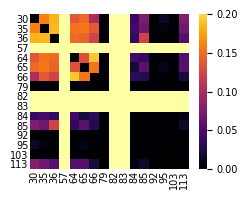

In [16]:
# combine H1 and H3

# initialize matrices to store values
total_epistasis = np.zeros((num_mutations_H1,num_mutations_H1),dtype=float)


    
muts_H3 = np.array([1,2,3,5,6,7,8,11,12,13,14,15,16])-1



for i in range(1,len(coefs_H3)):
    muts_involved = [int(x)-1 for x in names_H3[i].split(',')]
    if len(muts_involved) >= 3:
        if sig_H3[i]:
            for j in range(len(muts_involved)):
                for k in range(j+1,len(muts_involved)):
                    total_epistasis[muts_involved[k],muts_involved[j]] += np.abs(coefs_H3[i])
                    total_epistasis[muts_involved[j],muts_involved[k]] += np.abs(coefs_H3[i])


print(np.nanmin(total_epistasis),np.nanmax(total_epistasis))
min_val = np.nanmin(total_epistasis)
max_val = np.nanmax(total_epistasis)


overlay = np.full((num_mutations_H1,num_mutations_H1),np.nan)

for i in range(num_mutations_H1):
    overlay[i,i] = np.nan
    total_epistasis[i,i] = np.nan

    for j in [4,9,10]:
        overlay[j-1,i] = 1
        total_epistasis[j-1,i] = np.nan
        overlay[i,j-1] = 1
        total_epistasis[i,j-1] = np.nan
            
    
mpl.rc_file_defaults() 
plt.rcParams.update({'font.size': 7,"axes.facecolor": "k"})


cmap = plt.get_cmap('inferno')
new_cmap = truncate_colormap(cmap, 0,0.9)


plt.figure(figsize=(2.5,2))

sns.heatmap(total_epistasis,cmap=new_cmap,cbar_kws={"pad": 0.05},vmax=0.2) 
sns.heatmap(overlay,cmap=cmap,vmin=0,vmax=1,cbar=None) 

plt.xticks(np.arange(0.5,num_mutations_H1+0.5,1),mut_names,rotation='90')
plt.yticks(np.arange(0.5,num_mutations_H1+0.5,1),mut_names,rotation='0')
plt.tick_params(length=0,pad=1)

plt.tight_layout()
plt.savefig('images/9114_H3_3andup_total_'+ep_type+'.pdf')

plt.show()

# Variance partitioning

In [37]:
# read in genos and phenos
df = pd.read_csv('../../../CR9114/Kd_meanbin/kd_processed/20210427_HA_unadj_fil_merg.csv',dtype={"variant": str})
# H1
df_H1 = df.dropna(subset=['h1_mean'])
genos_H1 = np.array(df_H1[['pos'+x for x in H1_mutations]].copy(),dtype=np.float64)
phenos_H1 = df_H1[['h1_mean']].values.flatten()
print(genos_H1.shape,phenos_H1.shape)
genos_H1 = 2*genos_H1-1


poly_current_H1 = PolynomialFeatures(order_H1,interaction_only=True)
genos_current_H1 = poly_current_H1.fit_transform(genos_H1)

phenos_pred = np.tensordot(genos_current_H1,coefs_H1,axes=1)
pearsonr = np.corrcoef(phenos_pred,phenos_H1)[1,0]
print(pearsonr,pearsonr**2)


order_r2_H1 = []
for i in range(1,order_H1+1):
    phenos_pred = np.tensordot(genos_current_H1[:,:order_start_indices_H1[i]],coefs_H1[:order_start_indices_H1[i]],axes=1)
    pearsonr = np.corrcoef(phenos_pred,phenos_H1)[1,0]
    order_r2_H1.append(pearsonr**2)
print(order_r2_H1)
var_expl = np.array(order_r2_H1)/order_r2_H1[-1]

total_ep = 1-var_expl[0]
print(total_ep)

delta_ep = list(var_expl)
delta_ep.insert(0,0)
print(delta_ep)

delta_ep = [delta_ep[i]-delta_ep[i-1] for i in range(1,6)]
print(delta_ep)


(65094, 16) (65094,)
0.986670843178178 0.9735193527779367
[0.6503318130819457, 0.8930953827545407, 0.9545879255206181, 0.966222929756095, 0.9735193527779367]
0.3319785464703662
[0, 0.6680214535296338, 0.9173884219210371, 0.9805536200145403, 0.9925051073704685, 1.0]
[0.6680214535296338, 0.24936696839140327, 0.06316519809350318, 0.011951487355928214, 0.007494892629531513]


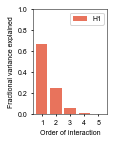

In [39]:
plt.figure(figsize=(1.6,2))
plt.bar(range(1,6),delta_ep,width=0.8,color=H1_color,label='H1')
plt.ylim([0,1])
plt.ylabel('Fractional variance explained')
plt.xlabel('Order of interaction')
plt.xticks([1,2,3,4,5],['1','2','3','4','5'])
plt.legend()
plt.tight_layout()
plt.savefig('images/9114_H1_var_partitioning.pdf')
plt.show()

In [26]:
# read in genos and phenos
df = pd.read_csv('../../../CR9114/Kd_meanbin/kd_processed/20210427_HA_unadj_fil_merg.csv',dtype={"variant": str})
# H3
# # for H3, filter for the three required mutations and remove them
df_H3 = df.dropna(subset=['h3_mean'])
for mut in H3_required_mutations:
    df_H3 = df_H3.loc[df_H3['pos'+mut] == 1]

genos_H3 = np.array(df_H3[['pos'+x for x in H3_mutations]].copy(),dtype=np.float64)
phenos_H3 = df_H3[['h3_mean']].values.flatten()
print(genos_H3.shape,phenos_H3.shape)
genos_H3 = 2*genos_H3-1


poly_current_H3 = PolynomialFeatures(order_H3,interaction_only=True)
genos_current_H3 = poly_current_H3.fit_transform(genos_H3)

phenos_pred = np.tensordot(genos_current_H3,coefs_H3,axes=1)
pearsonr = np.corrcoef(phenos_pred,phenos_H3)[1,0]
print(pearsonr,pearsonr**2)


order_r2_H3 = []
for i in range(1,order_H3+1):
    phenos_pred = np.tensordot(genos_current_H3[:,:order_start_indices_H3[i]],coefs_H3[:order_start_indices_H3[i]],axes=1)
    pearsonr = np.corrcoef(phenos_pred,phenos_H3)[1,0]
    order_r2_H3.append(pearsonr**2)
print(order_r2_H3)
var_expl = np.array(order_r2_H3)/order_r2_H3[-1]

total_ep = 1-var_expl[0]
print(total_ep)

delta_ep = list(var_expl)
delta_ep.insert(0,0)
print(delta_ep)

delta_ep = [delta_ep[i]-delta_ep[i-1] for i in range(1,order_H3+1)]
print(delta_ep)


(8192, 13) (8192,)
0.9876964929495002 0.9755443621847422
[0.7879895725677158, 0.9395417561314713, 0.9659112788761394, 0.9755443621847422]
0.19225654607546017
[0, 0.8077434539245398, 0.9630948550892727, 0.9901254277283409, 1.0]
[0.8077434539245398, 0.1553514011647329, 0.027030572639068162, 0.00987457227165911]


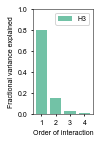

In [35]:
plt.figure(figsize=(1.4,2))
plt.bar(range(1,order_H3+1),delta_ep,width=0.8,color=H3_color,label='H3')
plt.ylim([0,1])
plt.ylabel('Fractional variance explained')
plt.xlabel('Order of interaction')
plt.xticks([1,2,3,4],['1','2','3','4','5'])
plt.legend()
plt.tight_layout()
plt.savefig('images/9114_H3_var_partitioning.pdf')
plt.show()